In [1]:
from os import listdir
import numpy as np
directory_name = "/home/saurav/Desktop/plantdisease/PlantVillage/Potato_Early_blight"
image_names = listdir(directory_name)


In [2]:
from PIL import Image
import cv2

imported_images = []

#resize all images in the dataset for processing
for image_name in image_names:
    foo = cv2.imread("/home/saurav/Desktop/plantdisease/PlantVillage/Potato_Early_blight/" + image_name)
    foo = cv2.resize(foo, (115, 115))
    imported_images.append(foo)

In [3]:
import numpy as np

#turn image into a 1D array
def process_image(image, width):
    out = []
    for x in range(width):
        for y in range(width):
            for z in range(3): 
                
                out.append(image[x][y][z])
    return np.asarray(out)

#process all images into 1D arrays
image_set = np.array([process_image(image, width = 115) for image in imported_images])

In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend as K

image_width = 115
pixels = image_width * image_width * 3
hidden = 1000
corruption_level = 0.25
X = tf.placeholder("float", [None, pixels], name = 'X')
mask = tf.placeholder("float", [None, pixels], name = 'mask')

weight_max = 4 * np.sqrt(4 / (6. * (pixels + hidden)))
weight_initial = tf.random_uniform(shape = [pixels, hidden], minval = -weight_max, maxval = weight_max)

W = tf.Variable(weight_initial, name = 'W')
b = tf.Variable(tf.zeros([hidden]), name = 'b')

W_prime = tf.transpose(W)
b_prime = tf.Variable(tf.zeros([pixels]), name = 'b_prime')

def reparameterize(W = W, b = b):
    epsilon = K.random_normal(shape = (1, hidden), mean = 0.)
    return W + K.exp(b/2) * epsilon

def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X

    hidden_state = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    out = tf.nn.sigmoid(tf.matmul(hidden_state, W_prime) + b_prime)
    return out

out = model(X, mask, W, b, W_prime, b_prime)

cost = tf.reduce_sum(tf.pow(X-out, 2))
optimization = tf.train.GradientDescentOptimizer(0.02).minimize(cost)

x_train, x_test = train_test_split(image_set)

sess = tf.Session()
#you need to initialize all variables
sess.run(tf.global_variables_initializer())
for i in range(1):
    for start, end in zip(range(0, len(x_train), 128), range(128, len(x_train), 128)):
        input_ = x_train[start:end]
        mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
        sess.run(optimization, feed_dict = {X: input_, mask: mask_np})
    mask_np = np.random.binomial(1, 1 - corruption_level, x_test.shape)
    print(i, sess.run(cost, feed_dict = {X: x_test, mask: mask_np}))

Using TensorFlow backend.


0 194583250000.0


In [5]:
masknp = np.random.binomial(1, 1 - corruption_level, image_set.shape)

def hidden_state(X, mask, W, b):
    tilde_X = mask * X
    
    state = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    return state

def euclidean_distance(arr1, arr2):
    x = 0
    for i in range(len(arr1)):
        x += pow(arr1[i] - arr2[i], 2)
    return np.sqrt(x)

def search(image):
    hidden_states = [sess.run(hidden_state(X, mask, W, b),
                              feed_dict={X: im.reshape(1, pixels), mask: np.random.binomial(1, 1-corruption_level, (1, pixels))})
                    for im in image_set]
    query = sess.run(hidden_state(X, mask, W, b),
                              feed_dict={X: image.reshape(1,pixels), mask: np.random.binomial(1, 1-corruption_level, (1, pixels))})
    starting_state = int(np.random.random()*len(hidden_states)) #choose random starting state
    best_states = [imported_images[starting_state]]
    distance = euclidean_distance(query[0], hidden_states[starting_state][0]) #Calculate similarity between hidden states
    for i in range(len(hidden_states)):
        dist = euclidean_distance(query[0], hidden_states[i][0])
        if dist <= distance:
            distance = dist #as the method progresses, it gets better at identifying similiar images
            best_states.append(imported_images[i])
    if len(best_states)>0:
        return best_states
    else:
        return best_states[len(best_states)-101:]

In [6]:
import matplotlib.pyplot as plt
image_name = "/home/saurav/Desktop/plantdisease/PlantVillage/Potato_Early_blight/0ad3ba53-f01b-403b-a99d-5991eed85045___RS_Early.B 7600.JPG" #Image to be used as query
image = cv2.imread(image_name)
image = cv2.resize(image, (115, 115))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
#        dist = euclidean_distance(query[0], hidden_states[i][0])

image = process_image(image, 115)

In [12]:
results = search(image)

16


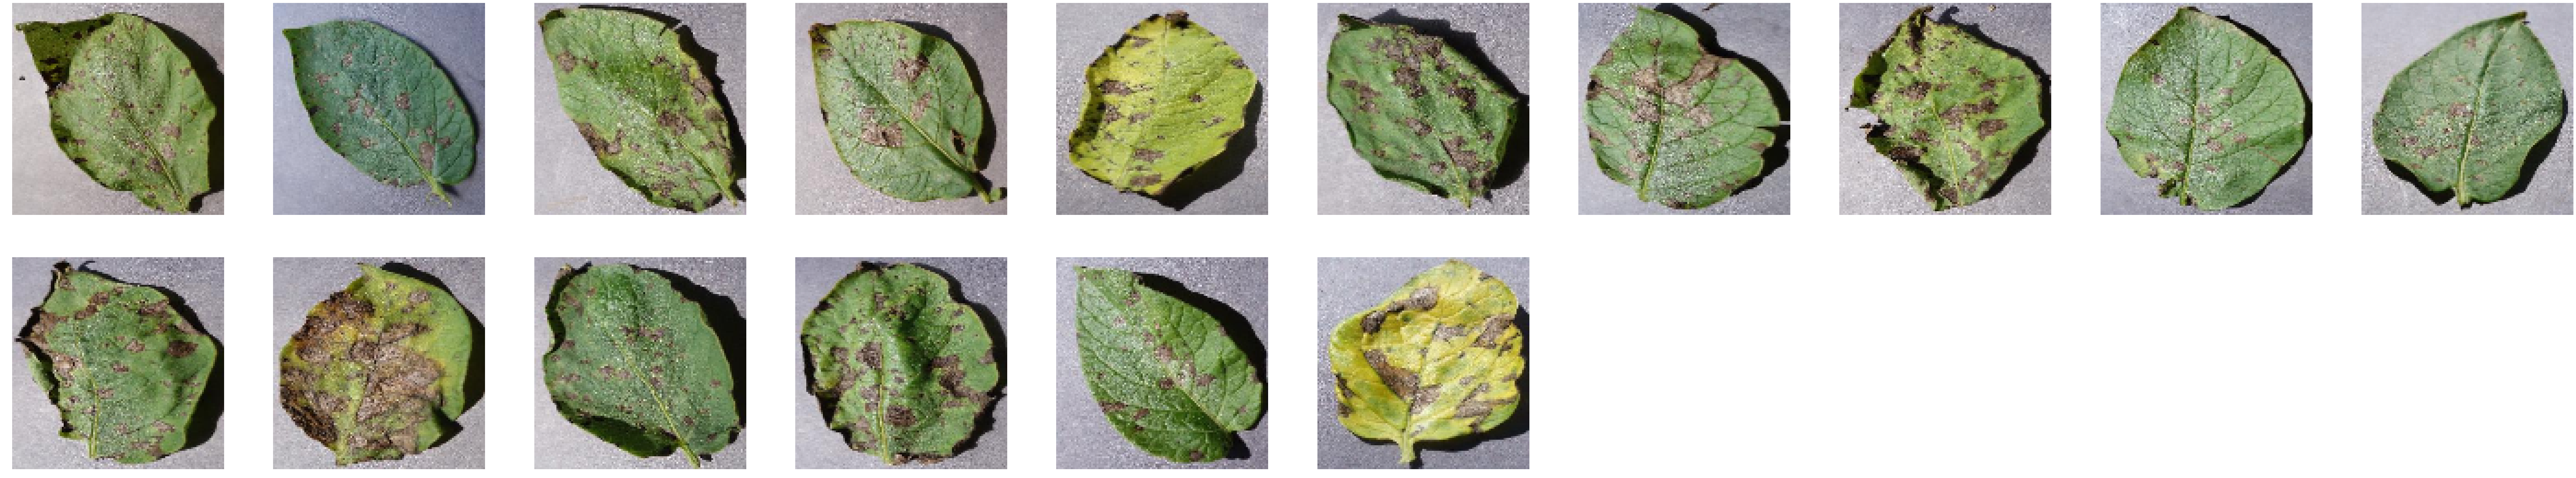

In [10]:
print(len(results))
slots = 0
plt.figure(figsize = (125,125))
for im in results[::-1]: 
    plt.subplot(10, 10, slots+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    slots += 1